## CIS 442 Final Project 
## Analyze customer sentiment from twitter data for airlines to make business recommendations for improvement

In [51]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn import svm
import scipy 
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import nltk


import matplotlib.pyplot as plt

In [52]:
# Input and clean up data by removing columns not useful for analysis
tweets = pd.read_csv('Tweets.csv')
del tweets['tweet_id']
del tweets['retweet_count']
del tweets['tweet_coord']
del tweets['name']
del tweets['tweet_created']
del tweets['user_timezone']
tweets.tail() 

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text,tweet_location
14635,positive,0.3487,NaN,0.0000,American,NaN,NaN,@AmericanAir thank you we got on a different f...,NaN
14636,negative,1.0000,Customer Service Issue,1.0000,American,NaN,NaN,@AmericanAir leaving over 20 minutes Late Flig...,Texas
14637,neutral,1.0000,NaN,NaN,American,NaN,NaN,@AmericanAir Please bring American Airlines to...,"Nigeria,lagos"
14638,negative,1.0000,Customer Service Issue,0.6659,American,NaN,NaN,"@AmericanAir you have my money, you change my ...",New Jersey
14639,neutral,0.6771,NaN,0.0000,American,NaN,NaN,@AmericanAir we have 8 ppl so we need 2 know h...,"dallas, TX"


In [53]:
# scanning data
print ("Airlines: ", tweets['airline'].dropna().unique())
print (" ")
print ("Airlines: ", tweets['airline_sentiment'].dropna().unique())
print (" ")
print ("Negative comments: ", tweets['negativereason'].dropna().unique())
print (" ")
print ("Locations: ", tweets['tweet_location'].dropna().unique())

Airlines:  ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
 
Airlines:  ['neutral' 'positive' 'negative']
 
Negative comments:  ['Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']
 
Locations:  ['Lets Play' 'San Francisco CA' 'Los Angeles' ..., 'Columbus, OH, USA'
 'Milwaukee County, Wisconsin' 'Nigeria,lagos']


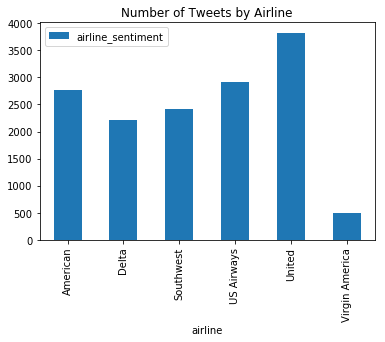

,airline_sentiment
airline,
American,2759
Delta,2222
Southwest,2420
US Airways,2913
United,3822
Virgin America,504


In [54]:
# Count of tweets by airline - sample size

df = tweets[['airline', 'airline_sentiment']]
a = pd.pivot_table(df, index = ['airline'], aggfunc = len)

a.plot(kind = 'bar', title = 'Number of Tweets by Airline')
plt.show()
a

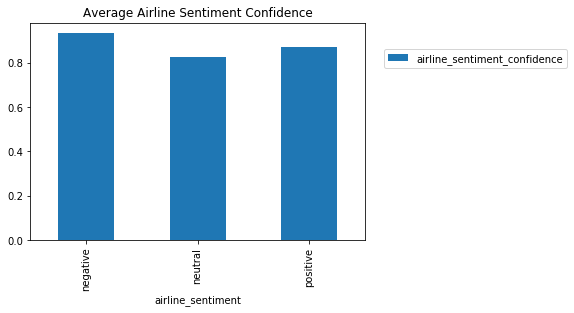

,airline_sentiment_confidence
airline_sentiment,
negative,0.933365
neutral,0.823303
positive,0.872039


In [55]:
# Average of sentiment confidence
df2 = tweets[['airline_sentiment', 'airline_sentiment_confidence']]

b = df2.groupby('airline_sentiment')['airline_sentiment_confidence'].mean()
b = pd.DataFrame(data = b)

ax = b.plot(kind = 'bar', title = 'Average Airline Sentiment Confidence')
ax.legend(loc = 9, bbox_to_anchor = (1.33,.9))
plt.show()
b

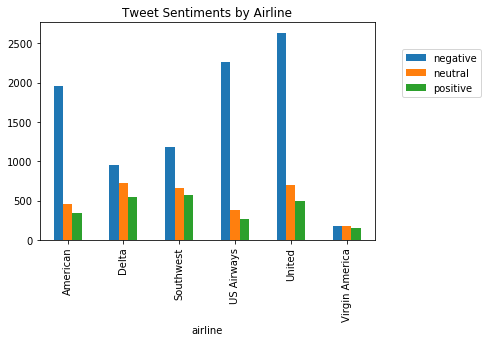

In [56]:
# Count of tweets by sentiment by airline
c = pd.pivot_table(df, index = ['airline', 'airline_sentiment'], aggfunc = len)
c = c.unstack('airline_sentiment')
ax = c.plot(kind = 'bar', title = 'Tweet Sentiments by Airline')

ax.legend(loc = 9, bbox_to_anchor = (1.2,.9))
plt.show()

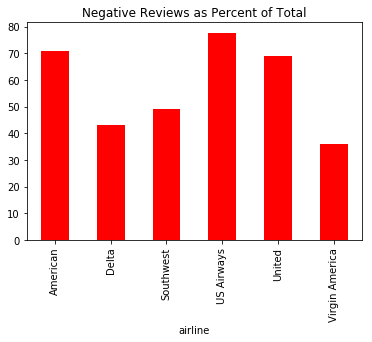

airline_sentiment,negative,neutral,positive,total,% negative
airline,,,,,
American,1960,463,336,2759,71.04
Delta,955,723,544,2222,42.98
Southwest,1186,664,570,2420,49.01
US Airways,2263,381,269,2913,77.69
United,2633,697,492,3822,68.89
Virgin America,181,171,152,504,35.91


In [57]:
# Plot negative reviews as percent of total
c2 = c
c2['total'] = c2['negative'] + c2['neutral'] + c2['positive']
c2['% negative'] = round(c2['negative'] / c2['total'],4)*100

c3 = c2['% negative']
c3.plot(kind = 'bar', color = 'r', title = 'Negative Reviews as Percent of Total')
plt.show()
c2

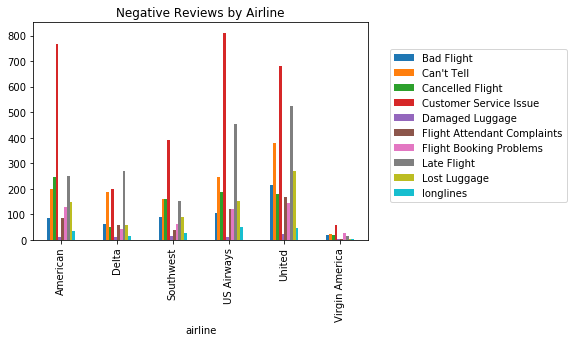

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
American,87,198,246,768,12,87,130,249,149,34
Delta,64,186,51,199,11,60,44,269,57,14
Southwest,90,159,162,391,14,38,61,152,90,29
US Airways,104,246,189,811,11,123,122,453,154,50
United,216,379,181,681,22,168,144,525,269,48
Virgin America,19,22,18,60,4,5,28,17,5,3


In [58]:
# Count of negative reviews by airline
df3 = tweets[['airline', 'negativereason']]

d = pd.pivot_table(df3, index = ['airline', 'negativereason'], aggfunc = len)
d = d.unstack('negativereason')

ax = d.plot(kind = 'bar', title = 'Negative Reviews by Airline')
ax.legend(loc = 9, bbox_to_anchor = (1.33,.9))
plt.show()
d

In [59]:
# Calculate negative review reasons as percent of total
d['total'] = d['Bad Flight'] + d["Can't Tell"] + d['Cancelled Flight'] + d['Customer Service Issue'] + d['Damaged Luggage'] + d['Flight Attendant Complaints'] + d['Flight Booking Problems'] + d['Late Flight'] +d['Lost Luggage'] + d['longlines']
d['% Bad Flight'] = round(d['Bad Flight'] / d['total'],4) * 100
d["Can't Tell"] = round(d["Can't Tell"] / d['total'],4) * 100
d['% Cancelled Flight'] = round(d['Cancelled Flight'] / d['total'],4) * 100
d['% Customer Service Issue'] = round(d['Customer Service Issue'] / d['total'],4) * 100
d['% Damaged Luggage'] = round(d['Damaged Luggage'] / d['total'],4) * 100
d['% Flight Attendant Complaints'] = round(d['Flight Attendant Complaints'] / d['total'],4) * 100
d['% Flight Booking Problems'] = round(d['Flight Booking Problems'] / d['total'],4) * 100
d['% Late Flight'] = round(d['Late Flight'] / d['total'],4) * 100
d['% Lost Luggage'] = round(d['Lost Luggage'] / d['total'],4) * 100
d['% longlines'] = round(d['longlines'] / d['total'],4) * 100

del d['Bad Flight']
del d["Can't Tell"]
del d['Cancelled Flight']
del d['Customer Service Issue']
del d['Damaged Luggage']
del d['Flight Attendant Complaints']
del d['Flight Booking Problems'] 
del d['Late Flight'] 
del d['Lost Luggage'] 
del d['longlines']
del d['total']

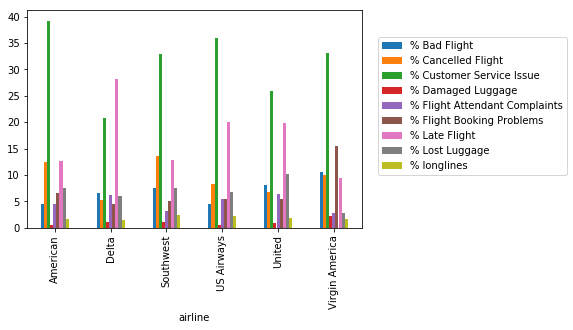

negativereason,% Bad Flight,% Cancelled Flight,% Customer Service Issue,% Damaged Luggage,% Flight Attendant Complaints,% Flight Booking Problems,% Late Flight,% Lost Luggage,% longlines
airline,,,,,,,,,
American,4.44,12.55,39.18,0.61,4.44,6.63,12.70,7.60,1.73
Delta,6.70,5.34,20.84,1.15,6.28,4.61,28.17,5.97,1.47
Southwest,7.59,13.66,32.97,1.18,3.20,5.14,12.82,7.59,2.45
US Airways,4.60,8.35,35.84,0.49,5.44,5.39,20.02,6.81,2.21
United,8.20,6.87,25.86,0.84,6.38,5.47,19.94,10.22,1.82
Virgin America,10.50,9.94,33.15,2.21,2.76,15.47,9.39,2.76,1.66


In [60]:
# Plot negative reviews as percent of total
ax = d.plot(kind = 'bar')
ax.legend(loc = 9, bbox_to_anchor = (1.33,.9))
plt.show()
d

In [91]:
# Predictive Modeling, predicted_sentiment based on twitter text.

tweets['predicted_sentiment'] = 'neutral'
tweets_train, tweets_test = train_test_split(tweets, test_size=0.10, random_state=42)
print ("Training: ", tweets_train.shape)
print ("Test: ", tweets_test.shape)

Training:  (13176, 10)
Test:  (1464, 10)


In [114]:
# Twitter text processing
# Reference: http://chrisalbon.com/python/cleaning_text.html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string

tweet_text = tweets_train['text']        # all the tweet text
str = tweet_text.str.lower().to_string() # dataframe to text for processing

tokens_training = nltk.word_tokenize(str)                            # tokenize
tokens_training = [i for i in tokens if i not in string.punctuation] # remove punctuation

stop_words = set(stopwords.words('english'))
tokens_training = [i for i in tokens if i not in stop_words]         # remove stop words
tokens_training = [i for i in tokens if   not i.isdigit()]           # remove numbers
tokens_training = [i for i in tokens if i.isalnum()]                 # remove alpha numeric characters
tokens_training

['united',
 'yes',
 'headed',
 'americanair',
 'missing',
 'full',
 'days',
 'work',
 'thank',
 'usairways',
 'mobile',
 'app',
 'horrible',
 'needs',
 'americanair',
 'checked',
 'app',
 'since',
 'yesterday',
 'united',
 'tried',
 'change',
 'flight',
 'thr',
 'decisions',
 'decisions',
 'mandarinjourney',
 'united',
 'southwestair',
 'sinuses',
 'contend',
 'americanair',
 'return',
 'flight',
 'scheduled',
 'usairways',
 'site',
 'clearly',
 'expl',
 'united',
 'items',
 'sentimental',
 'value',
 'jetblue',
 'process',
 'begins',
 'jetblue',
 'told',
 'jfk',
 'hour',
 'delay',
 'thi',
 'jetblue',
 'game',
 'buying',
 'americanair',
 'sure',
 'running',
 'version',
 'americanair',
 'wine',
 'served',
 'usairways',
 'flig',
 'jetblue',
 'fleet',
 'fleek',
 'http',
 'southwestair',
 'flights',
 'looking',
 'tomo',
 'southwestair',
 'wounded',
 'vets',
 'stuck',
 'hv',
 'trouble',
 'united',
 'special',
 'promotions',
 'jetblue',
 'booked',
 'flight',
 'guys',
 'jetblue',
 'yes',
 'slc

In [118]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *



In [42]:
# Patrick I am moving this to end as it overwrites df and I am yet not sure where this segment will fit.
# Word counter test code

df = pd.DataFrame({'Comment': ['This has has words words words that are written twice twice', 'This is a comment without repetitions', 'This comment, has ponctuations!']}, index = [0, 1, 2])
df
#you must create the new column before trying to assing any value
df['Words'] = ""

#counting frequencies
i = 0
for row in df['Comment']:
    df['Words'][i] = str(Counter(row.split()).most_common())
    i+=1

print(df)

                                             Comment  \
0  This has has words words words that are writte...   
1              This is a comment without repetitions   
2                    This comment, has ponctuations!   

                                               Words  
0  [('words', 3), ('has', 2), ('twice', 2), ('are...  
1  [('is', 1), ('comment', 1), ('without', 1), ('...  
2  [('This', 1), ('ponctuations!', 1), ('comment,...  


## References:

(1) Dataset - Kaggle

(2) www.nltk.org
